Задание 2

In [1]:
import numpy as np
import operator
from numpy.linalg import norm
from numpy.linalg import inv
from numpy.linalg import det
import math
from functools import reduce
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn-whitegrid')

In [2]:
def get_H(n, precision):
    # функция строит матрицу Гильберта размером n x n и округляет значения до precision знаков после запятой
    a = lambda i, j: round(1 / (i + j + 1), precision)
    return np.array([[a(i, j) for j in range(n)] for i in range(n)])

In [3]:
def get_W(n):
    # матрица Вандермонда
    return np.array([[(k + 1)**(j / 2) for j in range(1, n + 1)] for k in range(1, n + 1)])

In [4]:
cond_s = lambda A: norm(A) * norm(inv(A)) # norm - норма Фробениуса
    # Спектральный критерий

def cond_v(A):
    # Объемный критерий
    N = len(A)
    sqrt_sums = [math.sqrt(sum([A[n][m] ** 2 for m in range(N)])) for n in range(N)] # считаем для каждого n корень от суммы квадратов
    num = reduce(operator.mul, sqrt_sums, 1) # перемножаем
    den = abs(det(A))
    return num / den

def cond_a(A):
    # Угловой критерий
    N = len(A)
    C = inv(A)
    return max([norm(A[n,:]) * norm(C[:,n]) for n in range(N)])

In [5]:
def LU(A):
    # LU разложение
    n = len(A)
    M = []
    A_i = A
    for i in range(n):
        M_i = np.eye(n)
        for e in range(i + 1, n):
            M_i[e][i] = -(A_i[e][i] / A_i[i][i])
        M.append(M_i)
        A_i = M_i @ A_i

    L = np.eye(n)
    for i in range(n):
        L = L @ inv(M[i])

    return (L, A_i)

In [6]:
def solve_with_LU(A, b):
    # решение СЛАУ с помощью LU
    L, U = LU(A)
    n = len(A)

    for i in range(n):
        b[i] = b[i] / L[i][i]
        L[i][i] = 1
        for e in range(i + 1, n):
            b[e] -= L[e][i] * b[i]
            L[e][i] = 0
    
    for i in range(n - 1, -1, -1):
        b[i] = b[i] / U[i][i]
        U[i][i] = 1
        for e in range(0, i):
            b[e] -= U[e][i] * b[i]
            U[e][i] = 0

    return b

In [7]:
def print_conds(A, text):
    print(f"Condition numbers for {text}")
    print(int(cond_s(A)), int(cond_v(A)), int(cond_a(A)))

In [8]:
n = 10
H = get_H(n, 5)
x_0 = np.random.randint(-10, 10, n)
b = H @ x_0

L, U = LU(H)
print_conds(H, "H")
print_conds(L, "L")
print_conds(U, "U")

print("Error of the LU solution:")
print(norm(solve_with_LU(H, b) - x_0))

# print(LU(H)[0] @ LU(H)[1])

Condition numbers for H
1882905 32025174153062185026354971410432 256304
Condition numbers for L
580 559072 48
Condition numbers for U
1785714 116608 60
Error of the LU solution:
1.3996847372641076e-10


In [9]:
n = 3
W = get_W(n)
x_0 = np.random.randint(-10, 10, n)
b = W @ x_0

L, U = LU(W)
print_conds(W, "W")
print_conds(L, "L")
print_conds(U, "U")

print("Error of the LU solution:")
print(norm(solve_with_LU(W, b) - x_0))

Condition numbers for W
454 876 192
Condition numbers for L
10 4 3
Condition numbers for U
56 8 5
Error of the LU solution:
2.1846300548576003e-14


In [10]:
def test(A, x_0):
    b = A @ x_0
    data = []
    xs = np.logspace(-12, -1, 300)
    best_alpha = float('inf')
    best_norm = float('inf')
    for alpha in xs:
        x = np.linalg.solve(A + alpha * np.eye(n), b)
        reg_A = A + alpha * np.eye(n)
        data.append((cond_s(reg_A), cond_v(reg_A), cond_a(reg_A), norm(x_0 - x)))

        if norm(x_0 - x) < best_norm:
            best_norm = norm(x_0 - x)
            best_alpha = alpha

    df = pd.DataFrame(data, columns=['cond_s', 'cond_v', 'cond_a', 'error'])
    df['x'] = xs

    fig, axs = plt.subplots(2, 1, figsize=(15, 20), dpi=80)
    axs[0].tick_params(axis='both', which='major', labelsize=16)
    axs[0].tick_params(axis='both', which='minor', labelsize=16)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_ylabel('порядок величин', fontsize=20)
    axs[0].set_xlabel('alpha', fontsize=20)

    axs[0].plot(df['x'], df['cond_s'], label='Спектральный критерий')
    axs[0].plot(df['x'], df['cond_v'], label='Объемный критерий')
    axs[0].plot(df['x'], df['cond_a'], label='Угловой критерий')
    axs[0].plot(df['x'], df['error'],  label='Погрешность', linewidth=6)
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 20})
    axs[0].axvline(x=best_alpha, linestyle='dashed', color ='#000000')
  

    axs[1].tick_params(axis='both', which='major', labelsize=16)
    axs[1].tick_params(axis='both', which='minor', labelsize=16)
    axs[1].set_ylabel('погрешность', fontsize=20)
    axs[1].set_xlabel('alpha', fontsize=20)
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')

    axs[1].plot(df['x'], df['error'],  label='Погрешность', linewidth=2)
    axs[1].axvline(x=best_alpha, linestyle='dashed', color ='#000000')

    print("Best alpha:", best_alpha)
    print("Best error:", best_norm)
    return best_alpha

Best alpha: 2.297227536071156e-11
Best error: 9.616647193953715e-06
error on random x_1: 9.334911105428839


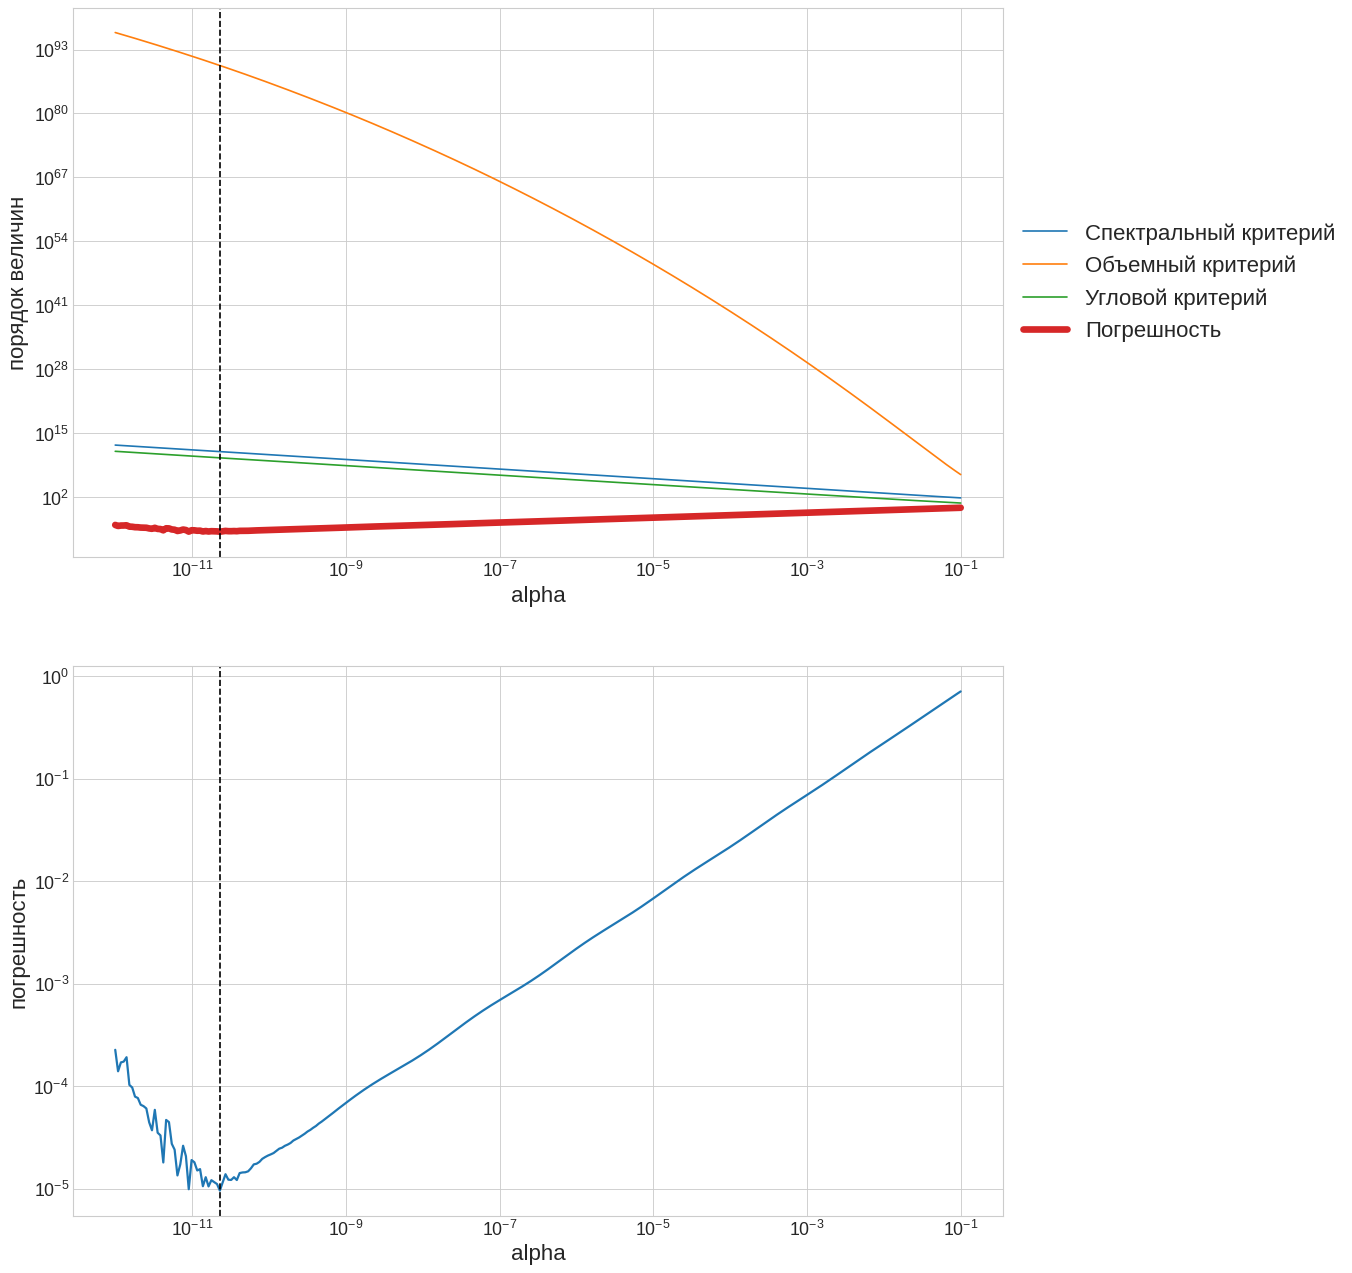

In [11]:
n = 15
A = get_H(n, 20)
x_0 = np.ones(n)

best_alpha = test(A, x_0)

x_1 = np.random.randint(-10, 10, n)
b_1 = A @ x_1
x = np.linalg.solve(A + best_alpha * np.eye(n), b_1) 
print("error on random x_1:", norm(x - x_1))


Best alpha: 1e-12
Best error: 12.329594259593739
error on random x_1: 15.871457115666432


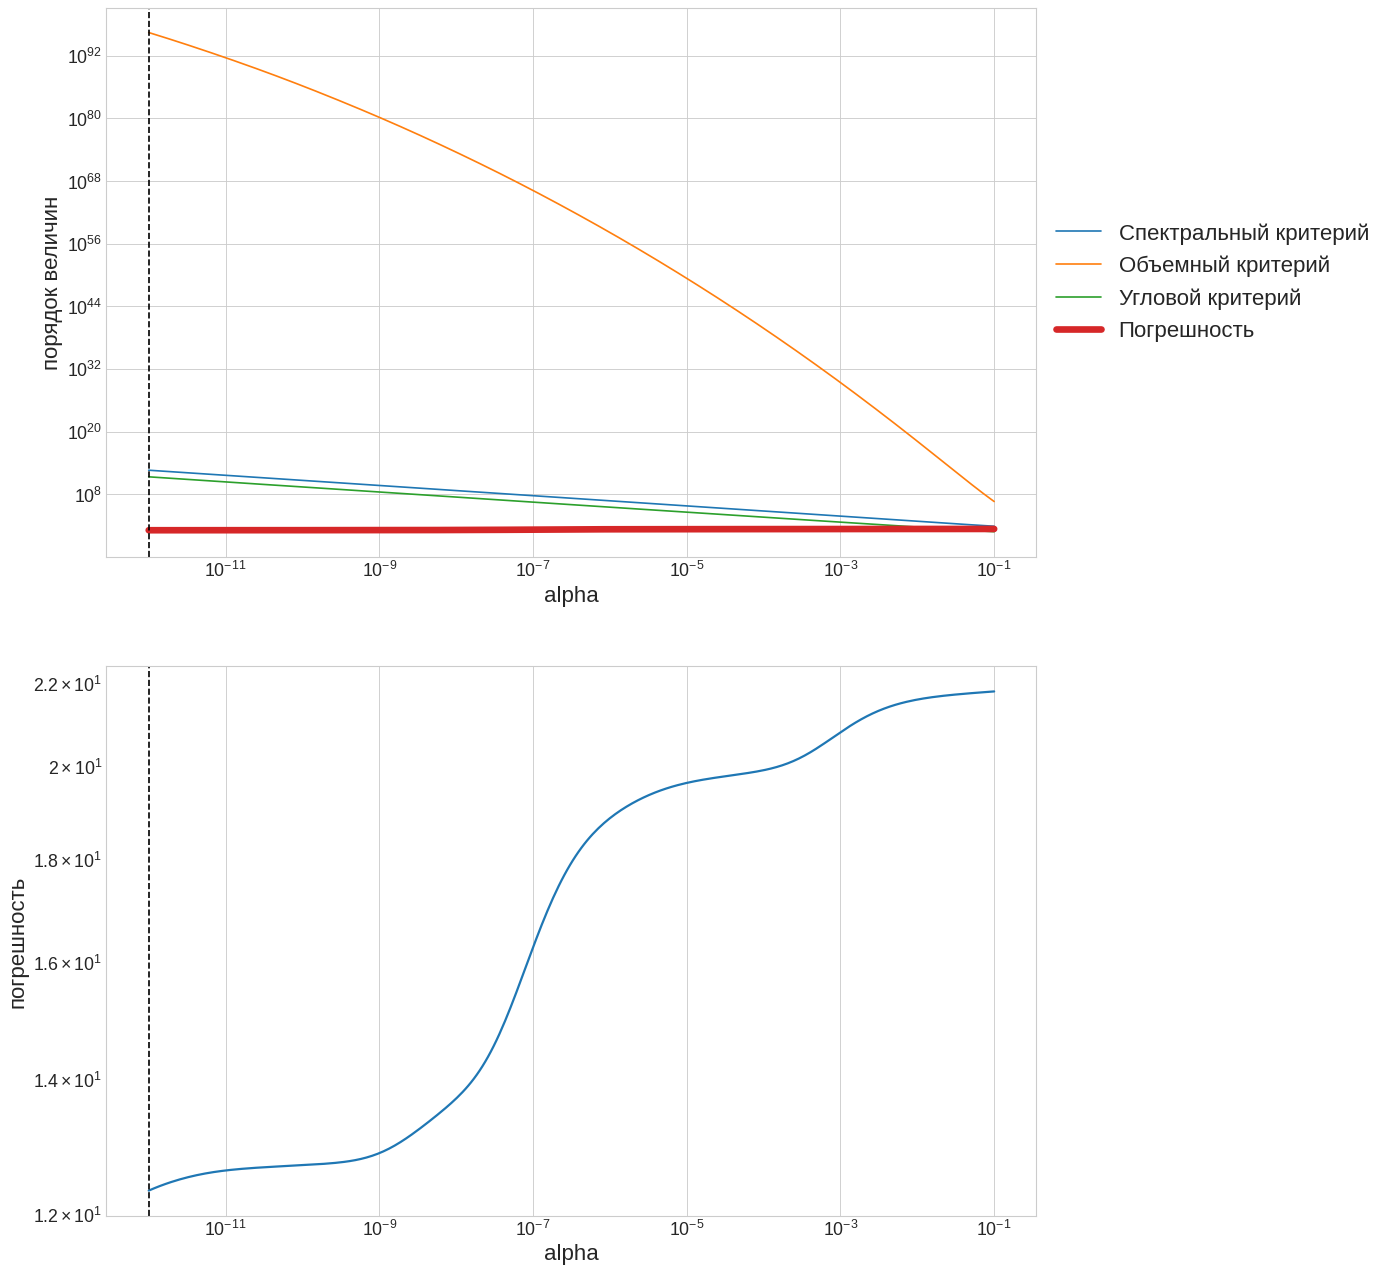

In [12]:
n = 15
A = get_H(n, 20)
x_0 = np.random.randint(-10, 10, n)

best_alpha = test(A, x_0)

x_1 = np.random.randint(-10, 10, n)
b_1 = A @ x_1
x = np.linalg.solve(A + best_alpha * np.eye(n), b_1) 
print("error on random x_1:", norm(x - x_1))


Best alpha: 1e-12
Best error: 1.0393542743529375e-10
error on random x_1: 1.9310390283747627e-10


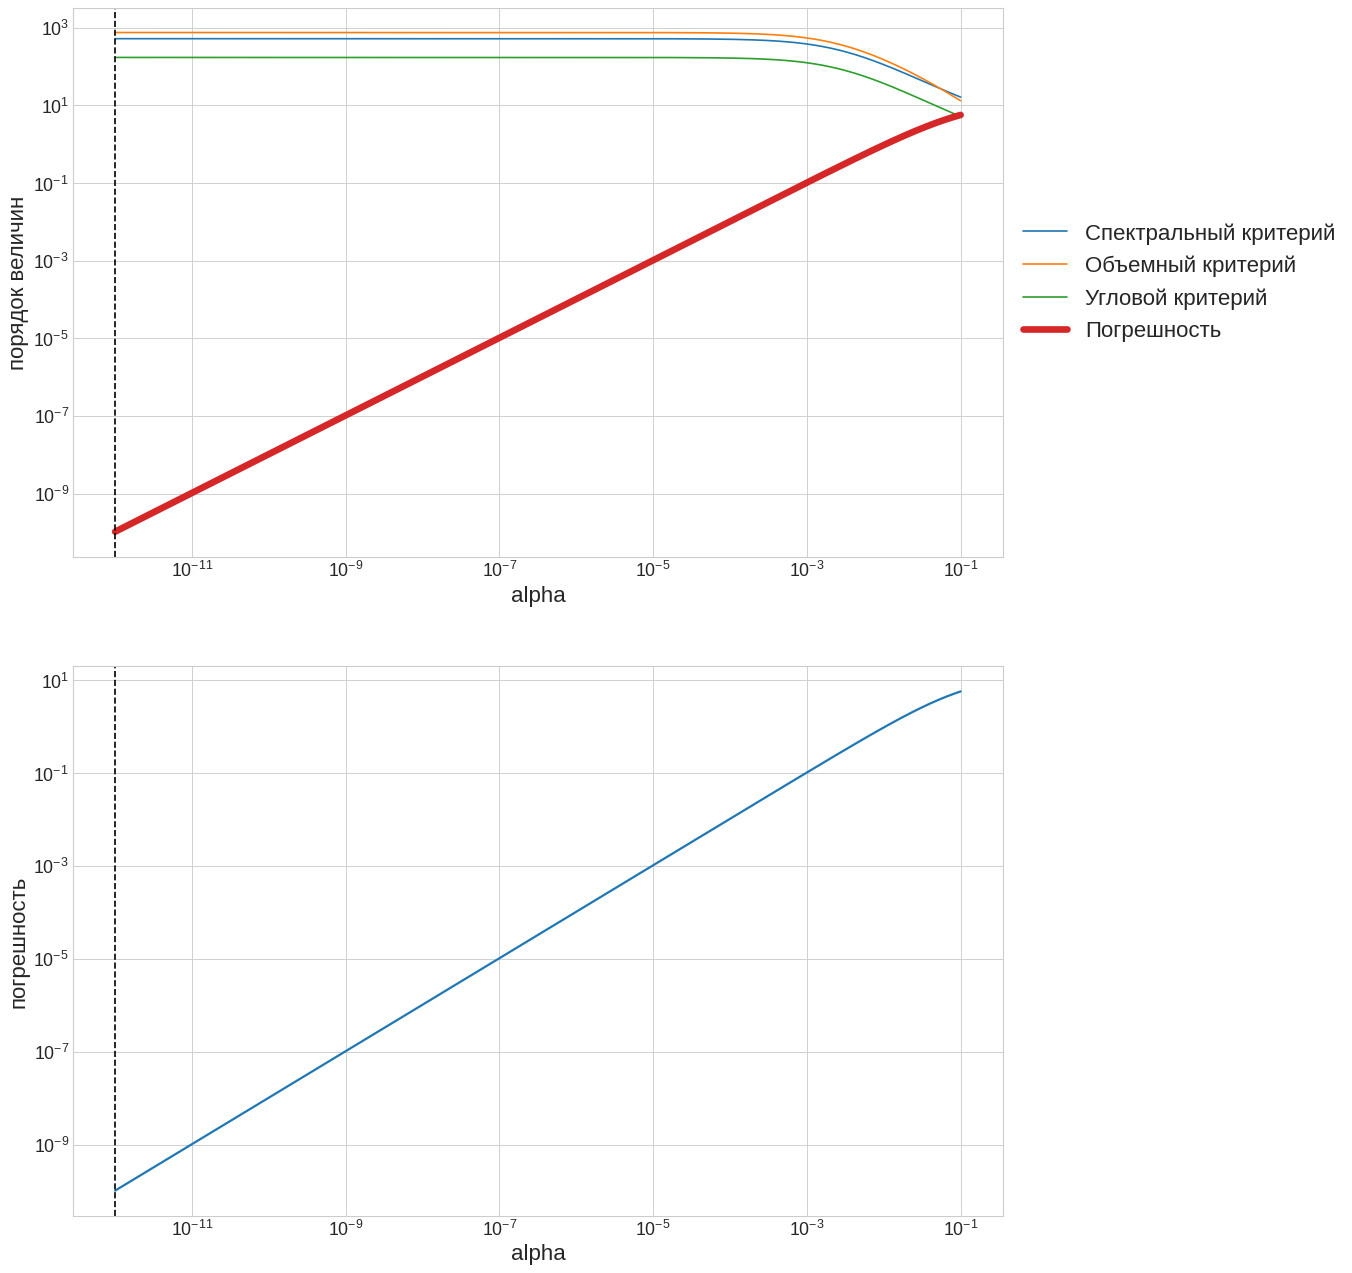

In [13]:
n = 3
A = get_H(n, 20)
x_0 = np.random.randint(-10, 10, n)

best_alpha = test(A, x_0)

x_1 = np.random.randint(-10, 10, n)
b_1 = A @ x_1
x = np.linalg.solve(A + best_alpha * np.eye(n), b_1) 
print("error on random x_1:", norm(x - x_1))


Задание 3 (Метод отражений)

In [14]:
def QR(A):
    n = len(A)
    A_i = A
    Qs = []
    for i in range(n - 1):
        a_i = A_i[i:, i]
        e_i = np.zeros(n - i)
        e_i[0] = 1
        w_i = np.array([(a_i - norm(a_i) * e_i) / norm(a_i - norm(a_i) * e_i)])
        
        U_i = np.eye(n - i) - 2 * w_i.T @ w_i.conjugate()
        U_i = np.block([[np.eye(i), np.zeros((i, n - i))], [np.zeros((n - i, i)), U_i]])
        A_i = U_i @ A_i 
        Qs.append(U_i)

    Q = np.eye(n)
    for q in Qs:
        Q = Q @ q

    return Q, A_i

In [15]:
def solve_QR(A, b):
    Q, R = QR(A)
    y = np.linalg.solve(Q, b)
    x = np.linalg.solve(R, y)
    return x 

In [16]:
n = 3
W = get_W(n)
x_0 = np.random.randint(-10, 10, n)
b = W @ x_0


Q, R = QR(W)

print(W)
print(Q @ R)

# L, U = LU(W)
print_conds(W, "W")
print_conds(Q, "Q")
print_conds(R, "R")

print("Error of the QR solution:")
print(norm(solve_QR(W, b) - x_0))

[[1.41421356 2.         2.82842712]
 [1.73205081 3.         5.19615242]
 [2.         4.         8.        ]]
[[1.41421356 2.         2.82842712]
 [1.73205081 3.         5.19615242]
 [2.         4.         8.        ]]
Condition numbers for W
454 876 192
Condition numbers for Q
3 1 1
Condition numbers for R
454 13 7
Error of the QR solution:
2.676679329863946e-13


In [17]:
n = 8
H = get_H(n, 20)
x_0 = np.random.randint(-10, 10, n)
b = H @ x_0


Q, R = QR(H)

# L, U = LU(W)
print_conds(H, "H")
print_conds(Q, "Q")
print_conds(R, "R")

print("Error of the QR solution:")
print(norm(solve_QR(H, b) - x_0))

Condition numbers for H
15493618665 756444835749694407536803840000 2025215248
Condition numbers for Q
8 0 1
Condition numbers for R
15493618708 23226 25
Error of the QR solution:
2.8190428249170503e-07
